In [16]:
import numpy as np
import os
from iminuit import Minuit
from iminuit.cost import LeastSquares
import iminuit
from natsort import natsorted
import matplotlib.pyplot as plt
import json

print(iminuit.__version__)
print("NumPy version:", np.__version__)

def power_law(x,a,b):
    return a*x**b

2.31.3
NumPy version: 2.3.4


In [17]:
# Fetch performance.json files
performance_files = []
for root, dirs, files in os.walk('.'):
    for file in files:
        if 'json' in file and 'performance' in file:
            performance_files.append(os.path.join(root, file))
    
performance_files = natsorted(performance_files)

print(f"Found performances files: \n")
for pf in performance_files:
    print(pf)
    
# sort files by concentration 0.4 and 0.6
performance_files_04 = [f for f in performance_files if int(f.split('-')[1])/(int(f.split('-')[2].split('/')[0])**3) == 0.4]
print("\nFiles with concentration 0.4:")
for pf in performance_files_04:
    print(pf)
performance_files_06 = [f for f in performance_files if int(f.split('-')[1])/(int(f.split('-')[2].split('/')[0])**3) == 0.6]
print("\nFiles with concentration 0.6:")
for pf in performance_files_06:
    print(pf)

Found performances files: 

./universal_benchmark-50000-50/performance_universal_benchmark-50000-50-run_20251128_170046.json
./universal_benchmark-75000-50/performance_universal_benchmark-75000-50-run_20251128_170110.json
./universal_benchmark-86400-60/performance_universal_benchmark-86400-60-run_20251128_170253.json
./universal_benchmark-129600-60/performance_universal_benchmark-129600-60-run_20251128_170400.json
./universal_benchmark-137200-70/performance_universal_benchmark-137200-70-run_20251129_113743.json
./universal_benchmark-204800-80/performance_universal_benchmark-204800-80-run_20251128_170917.json
./universal_benchmark-205800-70/performance_universal_benchmark-205800-70-run_20251129_114710.json
./universal_benchmark-291600-90/performance_universal_benchmark-291600-90-run_20251129_120214.json
./universal_benchmark-307200-80/performance_universal_benchmark-307200-80-run_20251128_171622.json
./universal_benchmark-400000-100/performance_universal_benchmark-400000-100-run_2025112

R² for p = 0.4 fit: 0.9619


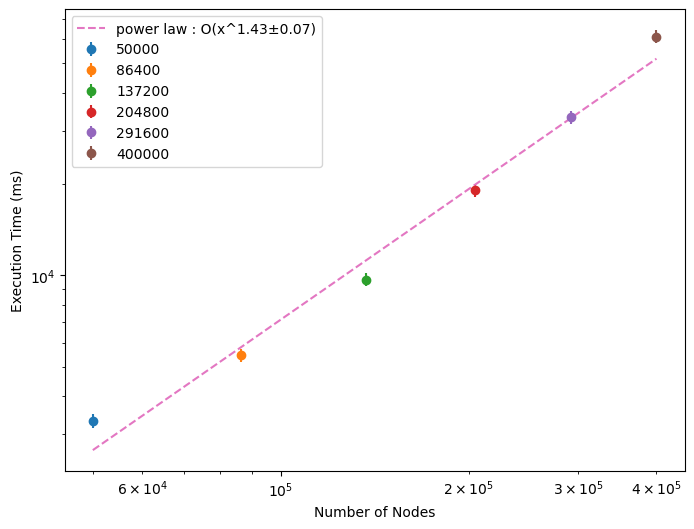

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
N = []
times = []
for pf in performance_files_04:
    with open(pf, 'r') as f:
        data = json.load(f)

    n_nodes = data['metrics']['number_nodes']
    time = data['execution_time_ms']
    ax.errorbar(n_nodes, time, time*0.05, fmt='o', label=os.path.basename(pf).split('-')[1])
    N.append(n_nodes)
    times.append(time)

x = np.array(N).flatten()
y = np.array(times).flatten()
dy = y * 0.1  # assuming 10% error

# Fit power law
cost = LeastSquares(x, y, dy, power_law)
m = Minuit(cost, a=-0.0001, b=1.7)
m.migrad()
m.hesse()
x_fit = np.linspace(min(x), max(x), 100)
y_fit = power_law(x_fit, m.values['a'], m.values['b'])
# compute R²
y_mean = np.mean(y)
ss_tot = np.sum((y - y_mean) ** 2)
ss_res = np.sum((y - power_law(x, m.values['a'], m.values['b'])) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print(f'R² for p = 0.4 fit: {r_squared:.4f}')
ax.loglog(x_fit, y_fit, label=f'power law : O(x^{m.values["b"]:.2f}±{m.errors['b']:.2f})', linestyle='--')


ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Execution Time (ms)')
ax.legend()
plt.show()

In [19]:
# Write to file
with open('performance_fit_04.dat', 'w') as f:
    f.write(f'# Fit results for probability 0.4\n')
    f.write(f'# a = {m.values["a"]} ± {m.errors["a"]}\n')
    f.write(f'# b = {m.values["b"]} ± {m.errors["b"]}\n')
    f.write(f'# R² = {r_squared}\n')
    for i in range(len(x)):
        f.write(f'{x[i]} {y[i]} {dy[i]}\n')

R² for p = 0.6 fit: 0.9777


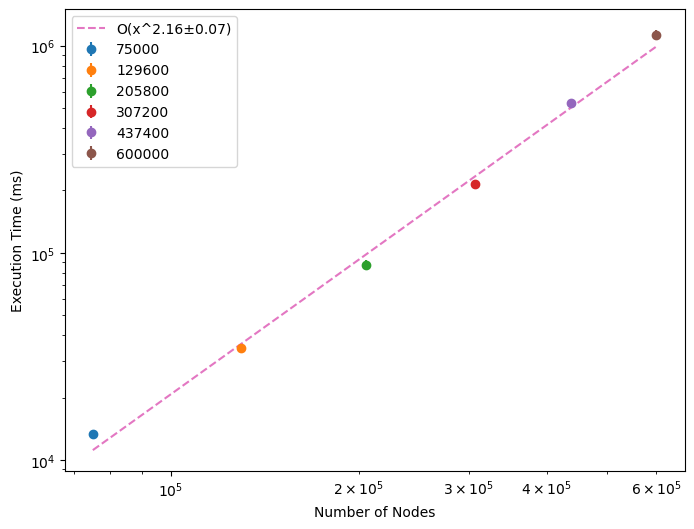

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
N = []
times = []
for pf in performance_files_06:
    with open(pf, 'r') as f:
        data = json.load(f)

    n_nodes = data['metrics']['number_nodes']
    time = data['execution_time_ms']
    ax.errorbar(n_nodes, time, time*0.05, fmt='o', label=os.path.basename(pf).split('-')[1])
    N.append(n_nodes)
    times.append(time)

x = np.array(N).flatten()
y = np.array(times).flatten()
dy = y * 0.1 # assuming 10% error

cost = LeastSquares(x, y, dy, power_law)
m = Minuit(cost, a=0.00001, b=2)
m.migrad()
m.hesse()
x_fit = np.linspace(min(x), max(x), 100)
y_fit = power_law(x_fit, m.values['a'], m.values['b'])
# compute R²
y_mean = np.mean(y)
ss_tot = np.sum((y - y_mean) ** 2)
ss_res = np.sum((y - power_law(x, m.values['a'], m.values['b'])) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print(f'R² for p = 0.6 fit: {r_squared:.4f}')
ax.loglog(x_fit, y_fit, label=f'O(x^{m.values["b"]:.2f}±{m.errors['b']:.2f})', linestyle='--')



ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Execution Time (ms)')
ax.legend()
plt.show()

In [21]:
# Write to file
with open('performance_fit_06.dat', 'w') as f:
    f.write(f'# Fit results for probability 0.6\n')
    f.write(f'# a = {m.values["a"]} ± {m.errors["a"]}\n')
    f.write(f'# b = {m.values["b"]} ± {m.errors["b"]}\n')
    f.write(f'# R² = {r_squared}\n')
    for i in range(len(x)):
        f.write(f'{x[i]} {y[i]} {dy[i]}\n')